In [1]:
!pip install -q git+https://github.com/tensorflow/docs

  Preparing metadata (setup.py) ... done


In [2]:
!!wget -q https://github.com/sayakpaul/Action-Recognition-in-TensorFlow/releases/download/v1.0.0/ucf101_top5.tar.gz
!tar xf ucf101_top5.tar.gz

In [3]:
import os
import keras
from imutils import paths
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import imageio
import cv2
from IPython.display import Image

In [4]:
IMG_SIZE = 224
BATCH_SIZE = 64
EPOCHS = 10

MAX_SEQ_LENGTH = 20
NUM_FEATURES = 2048

In [5]:
train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")

print(f"Total videos for training: {len(train_df)}")
print(f"Total videos for testing: {len(test_df)}")

train_df.sample(10)

Total videos for training: 594
Total videos for testing: 224


,video_name,tag
532,v_TennisSwing_g16_c01.avi,TennisSwing
573,v_TennisSwing_g22_c04.avi,TennisSwing
428,v_ShavingBeard_g18_c07.avi,ShavingBeard
106,v_CricketShot_g24_c03.avi,CricketShot
171,v_PlayingCello_g16_c02.avi,PlayingCello
141,v_PlayingCello_g11_c04.avi,PlayingCello
172,v_PlayingCello_g16_c03.avi,PlayingCello
184,v_PlayingCello_g18_c01.avi,PlayingCello
308,v_Punch_g18_c03.avi,Punch
87,v_CricketShot_g21_c02.avi,CricketShot


In [6]:
def crop_center_square(frame):
    y, x = frame.shape[0:2]
    min_dim = min(y, x)
    start_x = (x // 2) - (min_dim // 2)
    start_y = (y // 2) - (min_dim // 2)
    return frame[start_y : start_y + min_dim, start_x : start_x + min_dim]


def load_video(path, max_frames=0, resize=(IMG_SIZE, IMG_SIZE)):
    cap = cv2.VideoCapture(path)
    frames = []
    try:
        while True:
            ret, frame = cap.read()
            if not ret:
                break
            frame = crop_center_square(frame)
            frame = cv2.resize(frame, resize)
            frame = frame[:, :, [2, 1, 0]]
            frames.append(frame)

            if len(frames) == max_frames:
                break
    finally:
        cap.release()
    return np.array(frames)


In [7]:
def build_feature_extractor():
    feature_extractor = keras.applications.InceptionV3(
        weights="imagenet",
        include_top=False,
        pooling="avg",
        input_shape=(IMG_SIZE, IMG_SIZE, 3),
    )
    preprocess_input = keras.applications.inception_v3.preprocess_input

    inputs = keras.Input((IMG_SIZE, IMG_SIZE, 3))
    preprocessed = preprocess_input(inputs)

    outputs = feature_extractor(preprocessed)
    return keras.Model(inputs, outputs, name="feature_extractor")


feature_extractor = build_feature_extractor()

87910968/87910968 [==============================] - 0s 0us/step


In [8]:
label_processor = keras.layers.StringLookup(
    num_oov_indices=0, vocabulary=np.unique(train_df["tag"])
)
print(label_processor.get_vocabulary())

['CricketShot', 'PlayingCello', 'Punch', 'ShavingBeard', 'TennisSwing']


In [11]:
def prepare_all_videos(df, root_dir):
    num_samples = len(df)
    video_paths = df["video_name"].values.tolist()
    labels = label_processor(df["tag"])

    frame_features = np.zeros((num_samples, MAX_SEQ_LENGTH, NUM_FEATURES), dtype="float32")
    frame_masks = np.zeros((num_samples, MAX_SEQ_LENGTH), dtype="bool")

    for idx, path in enumerate(video_paths):
        frames = load_video(os.path.join(root_dir, path))

        # Limit the number of frames to MAX_SEQ_LENGTH
        frames = frames[:MAX_SEQ_LENGTH]

        # Extract features for each frame
        for i, frame in enumerate(frames):
            frame = cv2.resize(frame, (IMG_SIZE, IMG_SIZE))
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            frame = frame.astype("float32") / 255.0
            frame = np.expand_dims(frame, axis=0)
            feature = feature_extractor.predict(frame)
            frame_features[idx, i, :] = feature.squeeze()
            frame_masks[idx, i] = True  # Set mask for valid frame

    return frame_features, frame_masks, labels

train_data, train_masks, train_labels = prepare_all_videos(train_df, "train")
test_data, test_masks, test_labels = prepare_all_videos(test_df, "test")

print(f"Frame features in train set: {train_data.shape}")
print(f"Frame masks in train set: {train_masks.shape}")

Streaming output truncated to the last 5000 lines.
1/1 [==============================] - 0s 32ms/step
Frame features in train set: (594, 20, 2048)
Frame masks in train set: (594, 20)


In [13]:
def get_sequence_model():
    class_vocab = label_processor.get_vocabulary()

    frame_features_input = keras.Input((MAX_SEQ_LENGTH, NUM_FEATURES))
    mask_input = keras.Input((MAX_SEQ_LENGTH,), dtype="bool")

    # Use mask input in GRU layers
    x = keras.layers.GRU(16, return_sequences=True)(
        frame_features_input, mask=mask_input
    )
    x = keras.layers.GRU(8)(x)
    x = keras.layers.Dropout(0.4)(x)
    x = keras.layers.Dense(8, activation="relu")(x)
    output = keras.layers.Dense(len(class_vocab), activation="softmax")(x)

    rnn_model = keras.Model([frame_features_input, mask_input], output)

    rnn_model.compile(
        loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"]
    )
    return rnn_model

# Re-run the experiment
def run_experiment():
    filepath = "/tmp/video_classifier/ckpt.weights.h5"
    checkpoint = keras.callbacks.ModelCheckpoint(
        filepath, save_weights_only=True, save_best_only=True, verbose=1
    )

    seq_model = get_sequence_model()
    history = seq_model.fit(
        [train_data, train_masks],
        train_labels,
        validation_split=0.3,
        epochs=EPOCHS,
        callbacks=[checkpoint],
    )

    seq_model.load_weights(filepath)
    _, accuracy = seq_model.evaluate([test_data, test_masks], test_labels)
    print(f"Test accuracy: {round(accuracy * 100, 2)}%")

    return history, seq_model

_, sequence_model = run_experiment()

Epoch 1/10
13/13 [==============================] - ETA: 0s - loss: 1.4670 - accuracy: 0.2795
Epoch 1: val_loss improved from inf to 2.60334, saving model to /tmp/video_classifier/ckpt.weights.h5
13/13 [==============================] - 18s 211ms/step - loss: 1.4670 - accuracy: 0.2795 - val_loss: 2.6033 - val_accuracy: 0.0000e+00
Epoch 2/10
12/13 [==========================>...] - ETA: 0s - loss: 1.4457 - accuracy: 0.3151
Epoch 2: val_loss improved from 2.60334 to 2.45270, saving model to /tmp/video_classifier/ckpt.weights.h5
13/13 [==============================] - 0s 26ms/step - loss: 1.4423 - accuracy: 0.3133 - val_loss: 2.4527 - val_accuracy: 0.0000e+00
Epoch 3/10
13/13 [==============================] - ETA: 0s - loss: 1.3983 - accuracy: 0.3373
Epoch 3: val_loss did not improve from 2.45270
13/13 [==============================] - 0s 21ms/step - loss: 1.3983 - accuracy: 0.3373 - val_loss: 2.5836 - val_accuracy: 0.0000e+00
Epoch 4/10
13/13 [==============================] - ETA: 0s

Test video path: v_CricketShot_g02_c07.avi
1/1 [==============================] - 2s 2s/step
  Punch: 32.48%
  PlayingCello: 23.12%
  ShavingBeard: 21.26%
  CricketShot: 18.28%
  TennisSwing:  4.86%


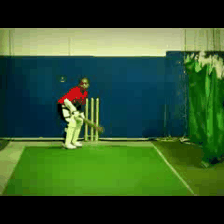

In [14]:

def prepare_single_video(frames):
    frames = frames[None, ...]
    frame_mask = np.zeros(
        shape=(
            1,
            MAX_SEQ_LENGTH,
        ),
        dtype="bool",
    )
    frame_features = np.zeros(shape=(1, MAX_SEQ_LENGTH, NUM_FEATURES), dtype="float32")

    for i, batch in enumerate(frames):
        video_length = batch.shape[0]
        length = min(MAX_SEQ_LENGTH, video_length)
        for j in range(length):
            frame_features[i, j, :] = feature_extractor.predict(batch[None, j, :])
        frame_mask[i, :length] = 1  # 1 = not masked, 0 = masked

    return frame_features, frame_mask


def sequence_prediction(path):
    class_vocab = label_processor.get_vocabulary()

    frames = load_video(os.path.join("test", path))
    frame_features, frame_mask = prepare_single_video(frames)
    probabilities = sequence_model.predict([frame_features, frame_mask])[0]

    for i in np.argsort(probabilities)[::-1]:
        print(f"  {class_vocab[i]}: {probabilities[i] * 100:5.2f}%")
    return frames


# This utility is for visualization.
# Referenced from:
# https://www.tensorflow.org/hub/tutorials/action_recognition_with_tf_hub
def to_gif(images):
    converted_images = images.astype(np.uint8)
    imageio.mimsave("animation.gif", converted_images, duration=100)
    return Image("animation.gif")


test_video = np.random.choice(test_df["video_name"].values.tolist())
print(f"Test video path: {test_video}")
test_frames = sequence_prediction(test_video)
to_gif(test_frames[:MAX_SEQ_LENGTH])